In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.preprocessing import StandardScaler
import os, sys
import cftime
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

2025-07-30 10:49:07.455185: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-30 10:49:07.495702: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dati

In [2]:
def read_csv(file_path, filename, varname):
    """
    Reads a CSV file, skips the first line and converts into into xarray.
    """
    ds = pd.read_csv(file_path+filename, skiprows=1, header=None, names=['time', varname], na_values=['NaN',-9999])
    ds['time'] = pd.to_datetime(ds['time'], format='%Y-%m-%d')

    ds = ds.set_index('time')
    ds = ds.to_xarray()
    ds['time'] = ds['time'].astype('datetime64[ns]')
    ds[varname] = ds[varname].astype('float32')

    return ds

In [3]:
def read_csv2(filepath):
    """
    Reads a CSV file and converts it to an xarray Dataset.
    """

    df = pd.read_csv(filepath, sep=';', skipinitialspace=True)
    
    df.columns = ['time', 'q']
    df['time'] = pd.to_datetime(df['time'], format='%Y%m%d')
    df.set_index('time', inplace=True)
    ds = df.to_xarray()
    
    return ds

In [4]:
def anom(xarr):
    #monthly mean anomaly (No-detrened)

    xarr_clm = xarr.groupby('time.month').mean('time')
    xarr_ano = xarr.groupby('time.month') - xarr_clm
    return xarr_ano, xarr_clm

In [5]:
path = '/home/amnd25/Desktop/Milano/Test_CDP_PhD/'

dmi = read_csv(path,'dmi.had.long.csv','dmi')
mei = read_csv(path,'mei.ext.long.csv','mei') # multivariate ENSO index
nao = read_csv(path,'nao.long.csv','nao')
nino3 = read_csv(path,'nino3.long.anom.csv','nino3')
nino4 = read_csv(path,'nino4.long.anom.csv','nino4')
nino12 = read_csv(path,'nino12.long.anom.csv','nino12')
nino34 = read_csv(path,'nino34.long.anom.csv','nino34')
pdo = read_csv(path,'pdo.timeseries.sstens.csv','pdo') # Pacific Decadal Oscillation
soi = read_csv(path,'soi.long.csv','soi') # Southern Oscillation Index
tsa = read_csv(path,'tsa.long.csv','tsa') # Tropical Southern Atlantic

data_names = ['dmi', 'mei', 'nao', 'nino3', 'nino4', 'nino12', 'nino34', 'pdo', 'soi', 'tsa'] # 10 climate indices
data_list =[dmi, mei, nao, nino3, nino4, nino12, nino34, pdo, soi, tsa]

In [6]:
streamflow = read_csv2(path+'Zambezi_at_BigTree_VicFalls_obs_discharge.txt')

streamflow_anom, streamflow_clm = anom(streamflow.q)

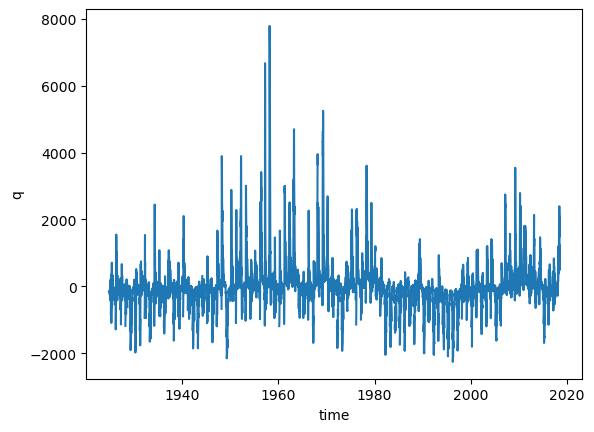

In [7]:
streamflow_anom.plot()

## Modello

In [8]:
data_names = ['mei', 'nino3', 'nino4', 'nino12', 'nino34', 'pdo', 'soi']
data_list =[mei, nino3, nino4, nino12, nino34, pdo, soi]
data_list_time_cropped = [ds.sel(time=slice('1924-10-01', '2018-07-11')) for ds in data_list]

In [9]:
window_size = 12
lag = 3           

monthly_streamflow = streamflow_anom.resample(time='MS').mean('time')
monthly_streamflow = monthly_streamflow.dropna('time')

optimal_lags = {
    'mei': 4,
    'nino3': 2,
    'nino4': 1,
    'nino12': 2,
    'nino34': 2,
    'pdo': 4,
    'soi': 4,}

climate_matrix = []

for nome, ds in zip(data_names, data_list_time_cropped):
    index_monthly = ds[nome].resample(time='MS').mean('time') # Make sure that they are monthly
    index_monthly = index_monthly.shift(time=optimal_lags[nome])  # Shift the index according to the optimal lag
    index_monthly = index_monthly.dropna('time') # Align with streamflow
    climate_matrix.append(index_monthly) 

climate_concat = xr.concat(climate_matrix, dim='variable') # Concatenate all climate indices along a new dimension
climate_concat['variable'] = data_names
climate_df = climate_concat.transpose('time', 'variable').to_pandas() # Transpose to have time as index and variables as columns
# We transpose because we want to align the climate indices with the streamflow time series
climate_df.columns = data_names

streamflow_series = monthly_streamflow.to_pandas()
climate_df, streamflow_aligned = climate_df.align(streamflow_series, join='inner', axis=0) # join='inner' to keep only the common dates

In [10]:
X = [] # Input features, past climate indices
y = [] # Target values, streamflow at t+lag, t+lag+1, t+lag+2

for i in range(len(climate_df) - window_size - lag - 2):  # -2 because we want three consecutive targets (t+lag, t+lag+1, t+lag+2)
    # lag = 3 because we want to predict three months into the future
    window = climate_df.iloc[i:i+window_size].values  # (12 months, 7 indices)
    targets = streamflow_aligned.iloc[i + window_size + lag - 1 : i + window_size + lag + 2]  # t+lag, t+lag+1, t+lag+2
    # i + window_size brings us to the end of the window, and lag - 1 gives us the index for t+lag

    if not np.isnan(window).any() and not np.isnan(targets).any(): # nan check
        X.append(window)
        y.append(targets.values)  # (3,)


X = np.array(X)
y = np.array(y)

In [11]:
# Standardization
scaler_X = StandardScaler()
X_reshaped = X.reshape(-1, X.shape[-1])  # (samples * 12, 7)
X_scaled = scaler_X.fit_transform(X_reshaped).reshape(X.shape)

scaler_y = StandardScaler() # we also standardize the y because we have multiple targets
y_scaled = scaler_y.fit_transform(y)  # shape (samples, 3)

In [12]:
print("Shape X:", X.shape)
print("Min:", np.min(X_scaled), "Max:", np.max(X_scaled))

print("Varianza media per feature:")
print(np.var(X_scaled, axis=(0, 1)))  # Variance must be similar across features

Shape X: (960, 12, 7)
Min: -3.206472671605132 Max: 4.867611275179305
Varianza media per feature:
[1. 1. 1. 1. 1. 1. 1.]


In [13]:
split_index = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
model = Sequential() # LSTM model, sequential because we have a sequence of past climate indices
model.add(LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False)) # 64 LSTM units, input shape is (window_size, number_of_features)
model.add(Dropout(0.4))  # 30% di neuroni “spenti” ad ogni batch
model.add(Dense(3))  # fully connected layer to output three targets (t+lag, t+lag+1, t+lag+2)

model.compile(loss='mse', optimizer='adam') # adam adaptive moment estimation optimizer, used because it adapts the learning rate during training
#model.fit(X_scaled, y_scaled, epochs=100, batch_size=32, validation_split=0.2, shuffle=False)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/100


/home/amnd25/anaconda3/envs/milano/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.8646 - val_loss: 0.6828
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.8127 - val_loss: 0.7277
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.7913 - val_loss: 0.7768
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.7850 - val_loss: 0.8238
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.7797 - val_loss: 0.8733
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.7823 - val_loss: 0.9212
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.7750 - val_loss: 0.9649
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.7800 - val_loss: 1.0035
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7725 - val_loss: 1.0393
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7618 - val_loss: 1.0833
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.7586 - val_loss: 1.1423
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.7

In [15]:
# Predizione
y_pred_scaled = model.predict(X_scaled)
# Rinormalizza (inverte lo StandardScaler)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


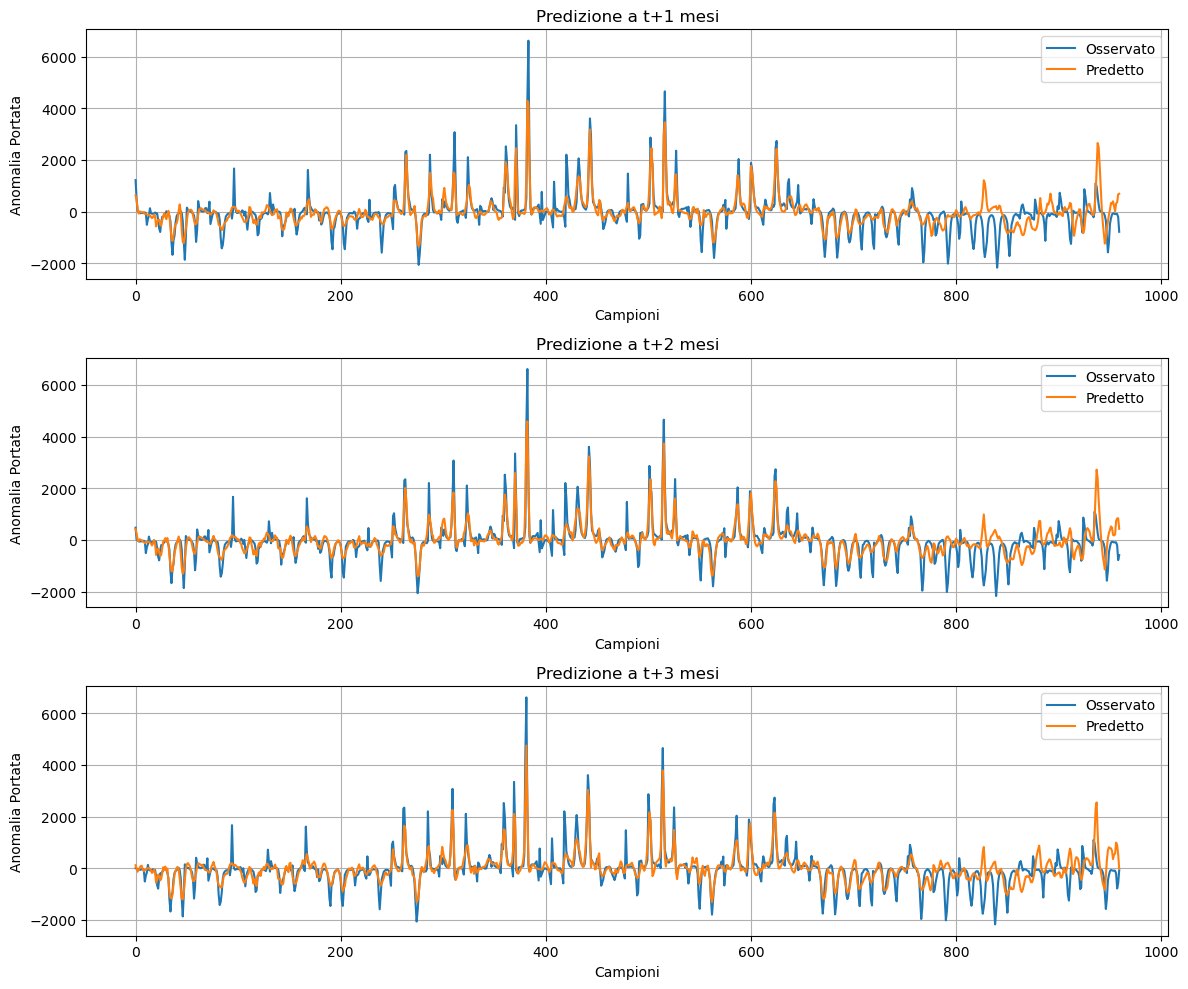

In [16]:
horizons = ['t+1', 't+2', 't+3']

plt.figure(figsize=(12, 10))

for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(y[:, i], label='Osservato')
    plt.plot(y_pred[:, i], label='Predetto')
    plt.title(f'Predizione a {horizons[i]} mesi')
    plt.xlabel('Campioni')
    plt.ylabel('Anomalia Portata')
    plt.legend()
    plt.grid(True)

plt.tight_layout()

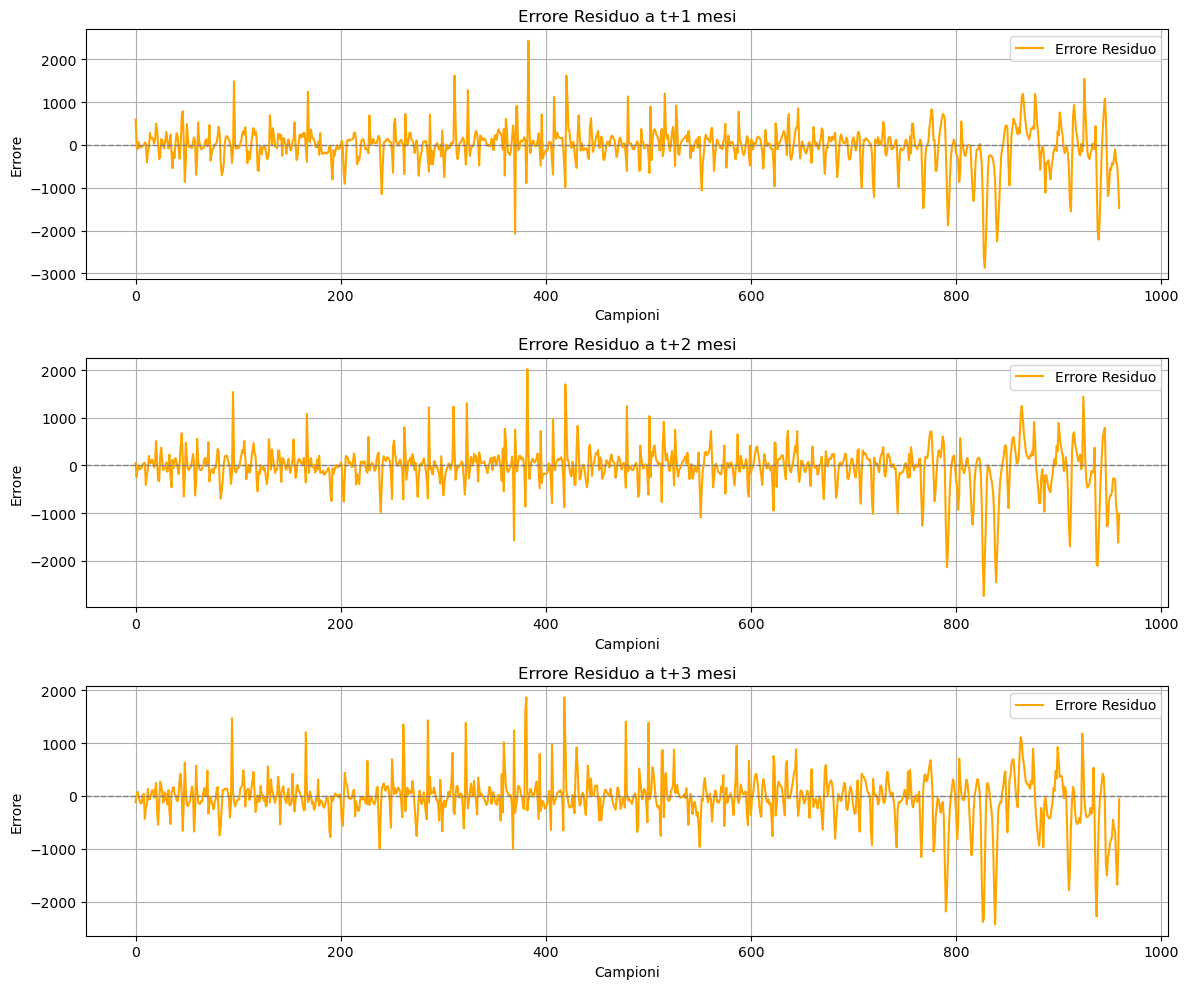

In [17]:
residuals = y - y_pred  # shape: (samples, 3)

plt.figure(figsize=(12, 10))
horizons = ['t+1', 't+2', 't+3']

for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(residuals[:, i], label='Errore Residuo', color='orange')
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.title(f"Errore Residuo a {horizons[i]} mesi")
    plt.xlabel("Campioni")
    plt.ylabel("Errore")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


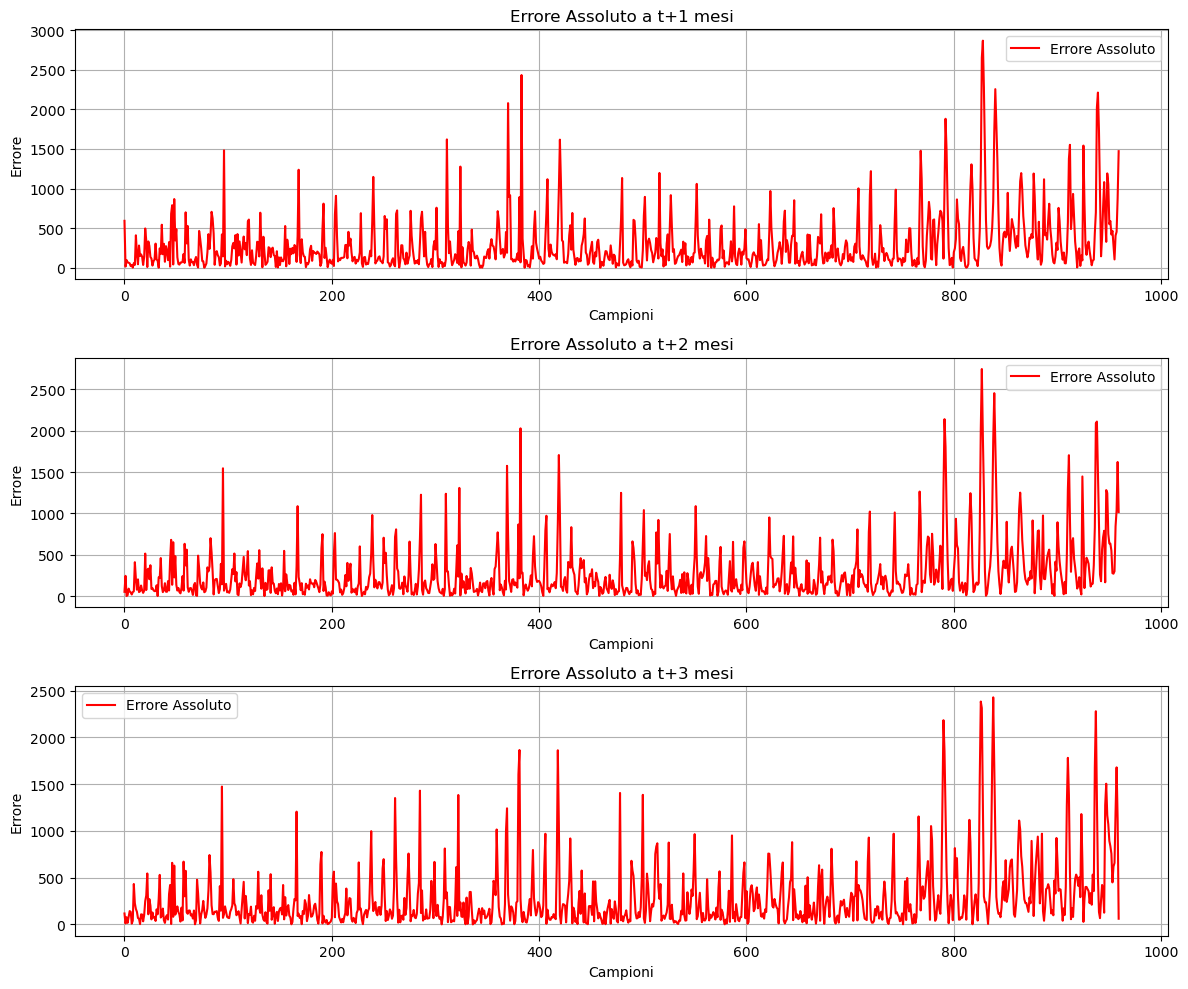

In [18]:
abs_error = np.abs(residuals)  # shape: (samples, 3)

plt.figure(figsize=(12, 10))

for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(abs_error[:, i], label='Errore Assoluto', color='red')
    plt.title(f"Errore Assoluto a {horizons[i]} mesi")
    plt.xlabel("Campioni")
    plt.ylabel("Errore")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


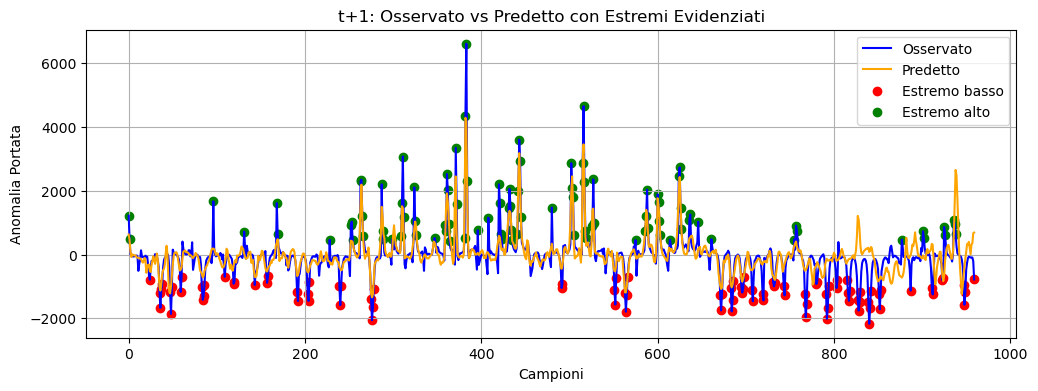

In [19]:
q10 = np.percentile(y[:, 0], 10)
q90 = np.percentile(y[:, 0], 90)

plt.figure(figsize=(12, 4))
plt.plot(y[:, 0], label='Osservato', color='blue')
plt.plot(y_pred[:, 0], label='Predetto', color='orange')

# Evidenzia estremi
plt.scatter(np.where(y[:, 0] < q10), y[:, 0][y[:, 0] < q10], color='red', label='Estremo basso')
plt.scatter(np.where(y[:, 0] > q90), y[:, 0][y[:, 0] > q90], color='green', label='Estremo alto')

plt.title("t+1: Osservato vs Predetto con Estremi Evidenziati")
plt.xlabel("Campioni")
plt.ylabel("Anomalia Portata")
plt.legend()
plt.grid(True)
plt.show()
